In [1]:
import os
import numpy as np
import rmgpy.chemkin
import rmgpy.tools.uncertainty

import matplotlib.pyplot as plt
%matplotlib inline

# Cpox Pt with lots of libraries

In [2]:
mech_dir = '/home/moon/uncertainty_estimator/nam29_presentation/cpox_Pt'
chemkin = os.path.join(mech_dir, 'chem_annotated-gas.inp')
surface = os.path.join(mech_dir, 'chem_annotated-surface.inp')
species_dict = os.path.join(mech_dir, 'species_dictionary.txt')

In [8]:
uncertainty = rmgpy.tools.uncertainty.Uncertainty(output_directory=os.path.join(mech_dir, 'rmg_uncertainty'))
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin, species_dict, surface_path=surface)
uncertainty.species_list = species_list
uncertainty.reaction_list = reaction_list

In [9]:
# --------------- CAUTION!!! Databases here must match the ones used to generate the mechanism
thermo_libs = [
    'surfaceThermoPt111',
    'primaryThermoLibrary',
    'thermo_DFT_CCSDTF12_BAC',
    'DFT_QCI_thermo'
]
kinetic_libs = [
    'Surface/CPOX_Pt/Deutschmann2006_adjusted',
    'BurkeH2O2inArHe'
]

In [10]:
kinetics_families = [
    'default',
    'Surface_Adsorption_Single',
    'Surface_Adsorption_vdW',
    'Surface_Adsorption_Dissociative',
    'Surface_Dissociation',
    'Surface_Abstraction',
    'Surface_Dissociation_Double_vdW',
    'Surface_Dissociation_vdW',
    'Surface_Abstraction_vdW',
    'Surface_Dissociation_Beta',
    'Surface_Adsorption_Bidentate',
    'Surface_Bidentate_Dissociation',
    'Surface_Monodentate_to_Bidentate',
    'Surface_Dissociation_to_Bidentate', 
    'Surface_vdW_to_Bidentate',
    'Surface_Adsorption_Dissociative_Double',
    'Surface_Abstraction_Beta',
    # 'Surface_Abstraction_Beta_double_vdW',
    'Surface_Dissociation_Double',
    'Surface_Dissociation_Beta_vdW',
    'Surface_Abstraction_Beta_vdW',
    'Surface_Abstraction_Single_vdW',
]

In [11]:
uncertainty.load_database(
    thermo_libraries=thermo_libs,
    kinetics_families=kinetics_families,
    reaction_libraries=kinetic_libs,
)

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2599,68.0494,74.7775,80.9311,90.8846,97.4337,105.393],'J/(mol*K)'), H298=(-477.191,'kJ/mol'), S298=(269.551,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(103.931,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)(Cds-Cd)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Li-OCOdO) + radical(OC=OOJ)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 2000.0 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2599,68.0494,74.7775,80.9311,90.8846,97.4337,105.393],'J/(mol*K)'), H298=(-477.191,'kJ/mol'), S298=(269.551,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(103.931,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)(Cds-Cd)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Li-OCOdO) + radical(OC=OOJ)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for En

# Generate "Before" thermo covariance

In [26]:
before_g_param_engine = rmgpy.tools.uncertainty.ThermoParameterUncertainty(
    dG_ADS=0.0,
    dG_ADS_group=0.0,
    dG_surf_lib=1.5
)



In [27]:
# Get the different kinetic and thermo sources
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties(g_param_engine=before_g_param_engine, correlated=True)
thermo_cov = uncertainty.get_thermo_covariance_matrix()
kinetic_cov = uncertainty.get_kinetic_covariance_matrix()
overall_cov = uncertainty.get_overall_covariance_matrix()

outdir = '/home/moon/uncertainty_estimator/nam29_presentation/cov_matrices/cpox_pt_many_lib/before'
np.save(os.path.join(outdir, 'thermo_cov.npy'), thermo_cov)
np.save(os.path.join(outdir, 'kinetic_cov.npy'), kinetic_cov)
np.save(os.path.join(outdir, 'overall_cov.npy'), overall_cov)

Text(0, 0.5, 'Surface Species              Gas Species')

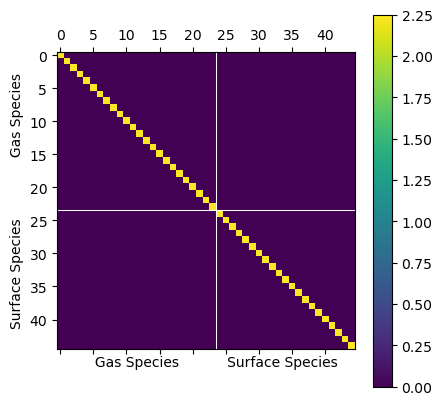

In [28]:
plt.matshow(uncertainty.thermo_covariance_matrix)
plt.colorbar()
# plt.clim([0, 0.1])

divider = np.argmax([x.contains_surface_site() for x in uncertainty.species_list]) - 0.5
plt.axvline(x=divider, color='w', linewidth=0.75)
plt.axhline(y=divider, color='w', linewidth=0.75)
plt.xlabel('     Gas Species           Surface Species')
plt.ylabel('Surface Species              Gas Species')
# plt.axvline(x=divider, color='w', linestyle='dashed', linewidth=0.75, dashes=(7, 10))
# plt.axhline(y=divider, color='w', linestyle='dashed', linewidth=0.75, dashes=(7, 10))

# Generate After thermo covariance

In [24]:
after_g_param_engine = rmgpy.tools.uncertainty.ThermoParameterUncertainty()
uncertainty.thermo_covariance_matrix = None
uncertainty.kinetic_covariance_matrix = None
uncertainty.overall_covariance_matrix = None
# Get the different kinetic and thermo sources
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties(g_param_engine=after_g_param_engine, correlated=True)
thermo_cov = uncertainty.get_thermo_covariance_matrix()
kinetic_cov = uncertainty.get_kinetic_covariance_matrix()
overall_cov = uncertainty.get_overall_covariance_matrix()

outdir = '/home/moon/uncertainty_estimator/nam29_presentation/cov_matrices/cpox_pt_many_lib/after_defaults'
np.save(os.path.join(outdir, 'thermo_cov.npy'), thermo_cov)
np.save(os.path.join(outdir, 'kinetic_cov.npy'), kinetic_cov)
np.save(os.path.join(outdir, 'overall_cov.npy'), overall_cov)

Text(0, 0.5, 'Surface Species              Gas Species')

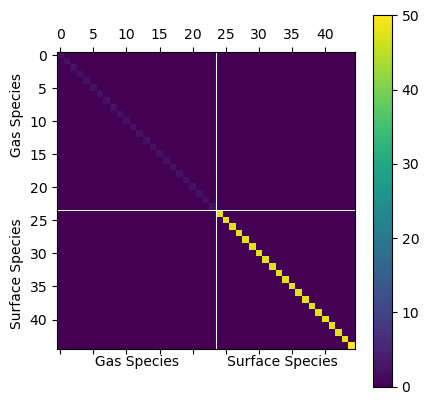

In [25]:
plt.matshow(uncertainty.thermo_covariance_matrix)
plt.colorbar()
# plt.clim([0, 0.1])

divider = np.argmax([x.contains_surface_site() for x in uncertainty.species_list]) - 0.5
plt.axvline(x=divider, color='w', linewidth=0.75)
plt.axhline(y=divider, color='w', linewidth=0.75)
plt.xlabel('     Gas Species           Surface Species')
plt.ylabel('Surface Species              Gas Species')
# plt.axvline(x=divider, color='w', linestyle='dashed', linewidth=0.75, dashes=(7, 10))
# plt.axhline(y=divider, color='w', linestyle='dashed', linewidth=0.75, dashes=(7, 10))